<a href="https://colab.research.google.com/github/srujaan/DL-with-PyTorch/blob/master/UsingTorchNNmodule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# We reshape our B inputs to B × Nin, 
# where Nin is 1. That is easily done with unsqueeze :
# to use nn.lineaer

t_c = torch.tensor(t_c).unsqueeze(1) # Adds the extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) # Adds the extra dimension at axis 1

t_u.shape, t_c.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

In [8]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 4,  1,  0,  6,  8,  3,  9,  7, 10]), tensor([2, 5]))

In [9]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val


In [10]:
# update the training code with nn.linear

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(), # This method call replaces[params]
    lr = 1e-2)

In [11]:
# Now we can use the parameters method to ask any nn.Module for
# a list of parameters owned by it or any of its submodules:

linear_model.parameters()

<generator object Module.parameters at 0x7fc11dbe3f10>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.0297]], requires_grad=True), Parameter containing:
 tensor([0.0630], requires_grad=True)]

In [13]:
# Training loop

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, 
                  t_c_train, t_c_val):
  for epoch in range(1, n_epochs + 1):
    t_p_train = model(t_u_train) # The model is now passed in, instead of params
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val) # The model is now passed in, instead of params

    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward() # The loss function is also passed in. We'll use it in a moment
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
      f" Validation loss {loss_val.item():.4f}")


In [14]:
linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-1.3435],
        [-1.2310]], grad_fn=<AddmmBackward>)

In [16]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # we no longer using our hand written loss function from earlier
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 87.7353, Validation loss 45.5313
Epoch 1000, Training loss 3.9171, Validation loss 1.4668
Epoch 2000, Training loss 3.3592, Validation loss 1.0954
Epoch 3000, Training loss 3.3497, Validation loss 1.0533

Parameter containing:
tensor([[5.3263]], requires_grad=True)
Parameter containing:
tensor([-17.1012], requires_grad=True)


In [17]:
# Building a neural network using nn.sequential

seq_model = nn.Sequential(
            nn.Linear(1, 13), # we choose 13 arbitarly. We wanted a number that was a different size
            nn.Tanh(),        # from the other tensor shapes we have floating around
            nn.Linear(13, 1)) # This 13 must match the first size, however

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [18]:
# Calling model.parameters() will collect weight and 
# bias from both the first and second linear modules.

[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [19]:
# A few notes on parameters of nn.Modules . When inspecting parameters of a model
# made up of several submodules, it is handy to be able to identify parameters by name.

for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [20]:
# Interestingly, Sequential also accepts an OrderedDict , in
# which we can name each module passed to Sequential

from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
            ('hidden_layer', nn.Linear(1, 8)), # Here again 8 is just arbitary number
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(8, 1))                           
]))

seq_model

Sequential(
  (hidden_layer): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
# Easy access of names

for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_layer.weight torch.Size([8, 1])
hidden_layer.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [24]:
# We can also access a particular Parameter by using submodules as attributes

seq_model.output_linear.bias

Parameter containing:
tensor([-0.0928], requires_grad=True)

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # we've dropped the learning_rate a bit to help with stability


In [26]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_train))
print('answer', t_c_val)
print('hidden', seq_model.hidden_layer.weight.grad)

Epoch 1, Training loss 193.7944, Validation loss 140.5837
Epoch 1000, Training loss 5.4912, Validation loss 0.6508
Epoch 2000, Training loss 3.5400, Validation loss 4.8730
Epoch 3000, Training loss 2.2719, Validation loss 3.6494
Epoch 4000, Training loss 2.0770, Validation loss 3.8203
Epoch 5000, Training loss 1.8905, Validation loss 3.4122
output tensor([[11.9753],
        [11.7014],
        [ 1.9441],
        [ 1.2596],
        [ 7.2729],
        [28.0887],
        [14.9735],
        [-3.6550],
        [21.1532]], grad_fn=<AddmmBackward>)
answer tensor([[15.],
        [ 8.]])
hidden tensor([[ -2.1489],
        [ -8.6211],
        [ -0.8090],
        [-10.6051],
        [ -0.3861],
        [  0.7917],
        [-11.4097],
        [ -1.8144]])


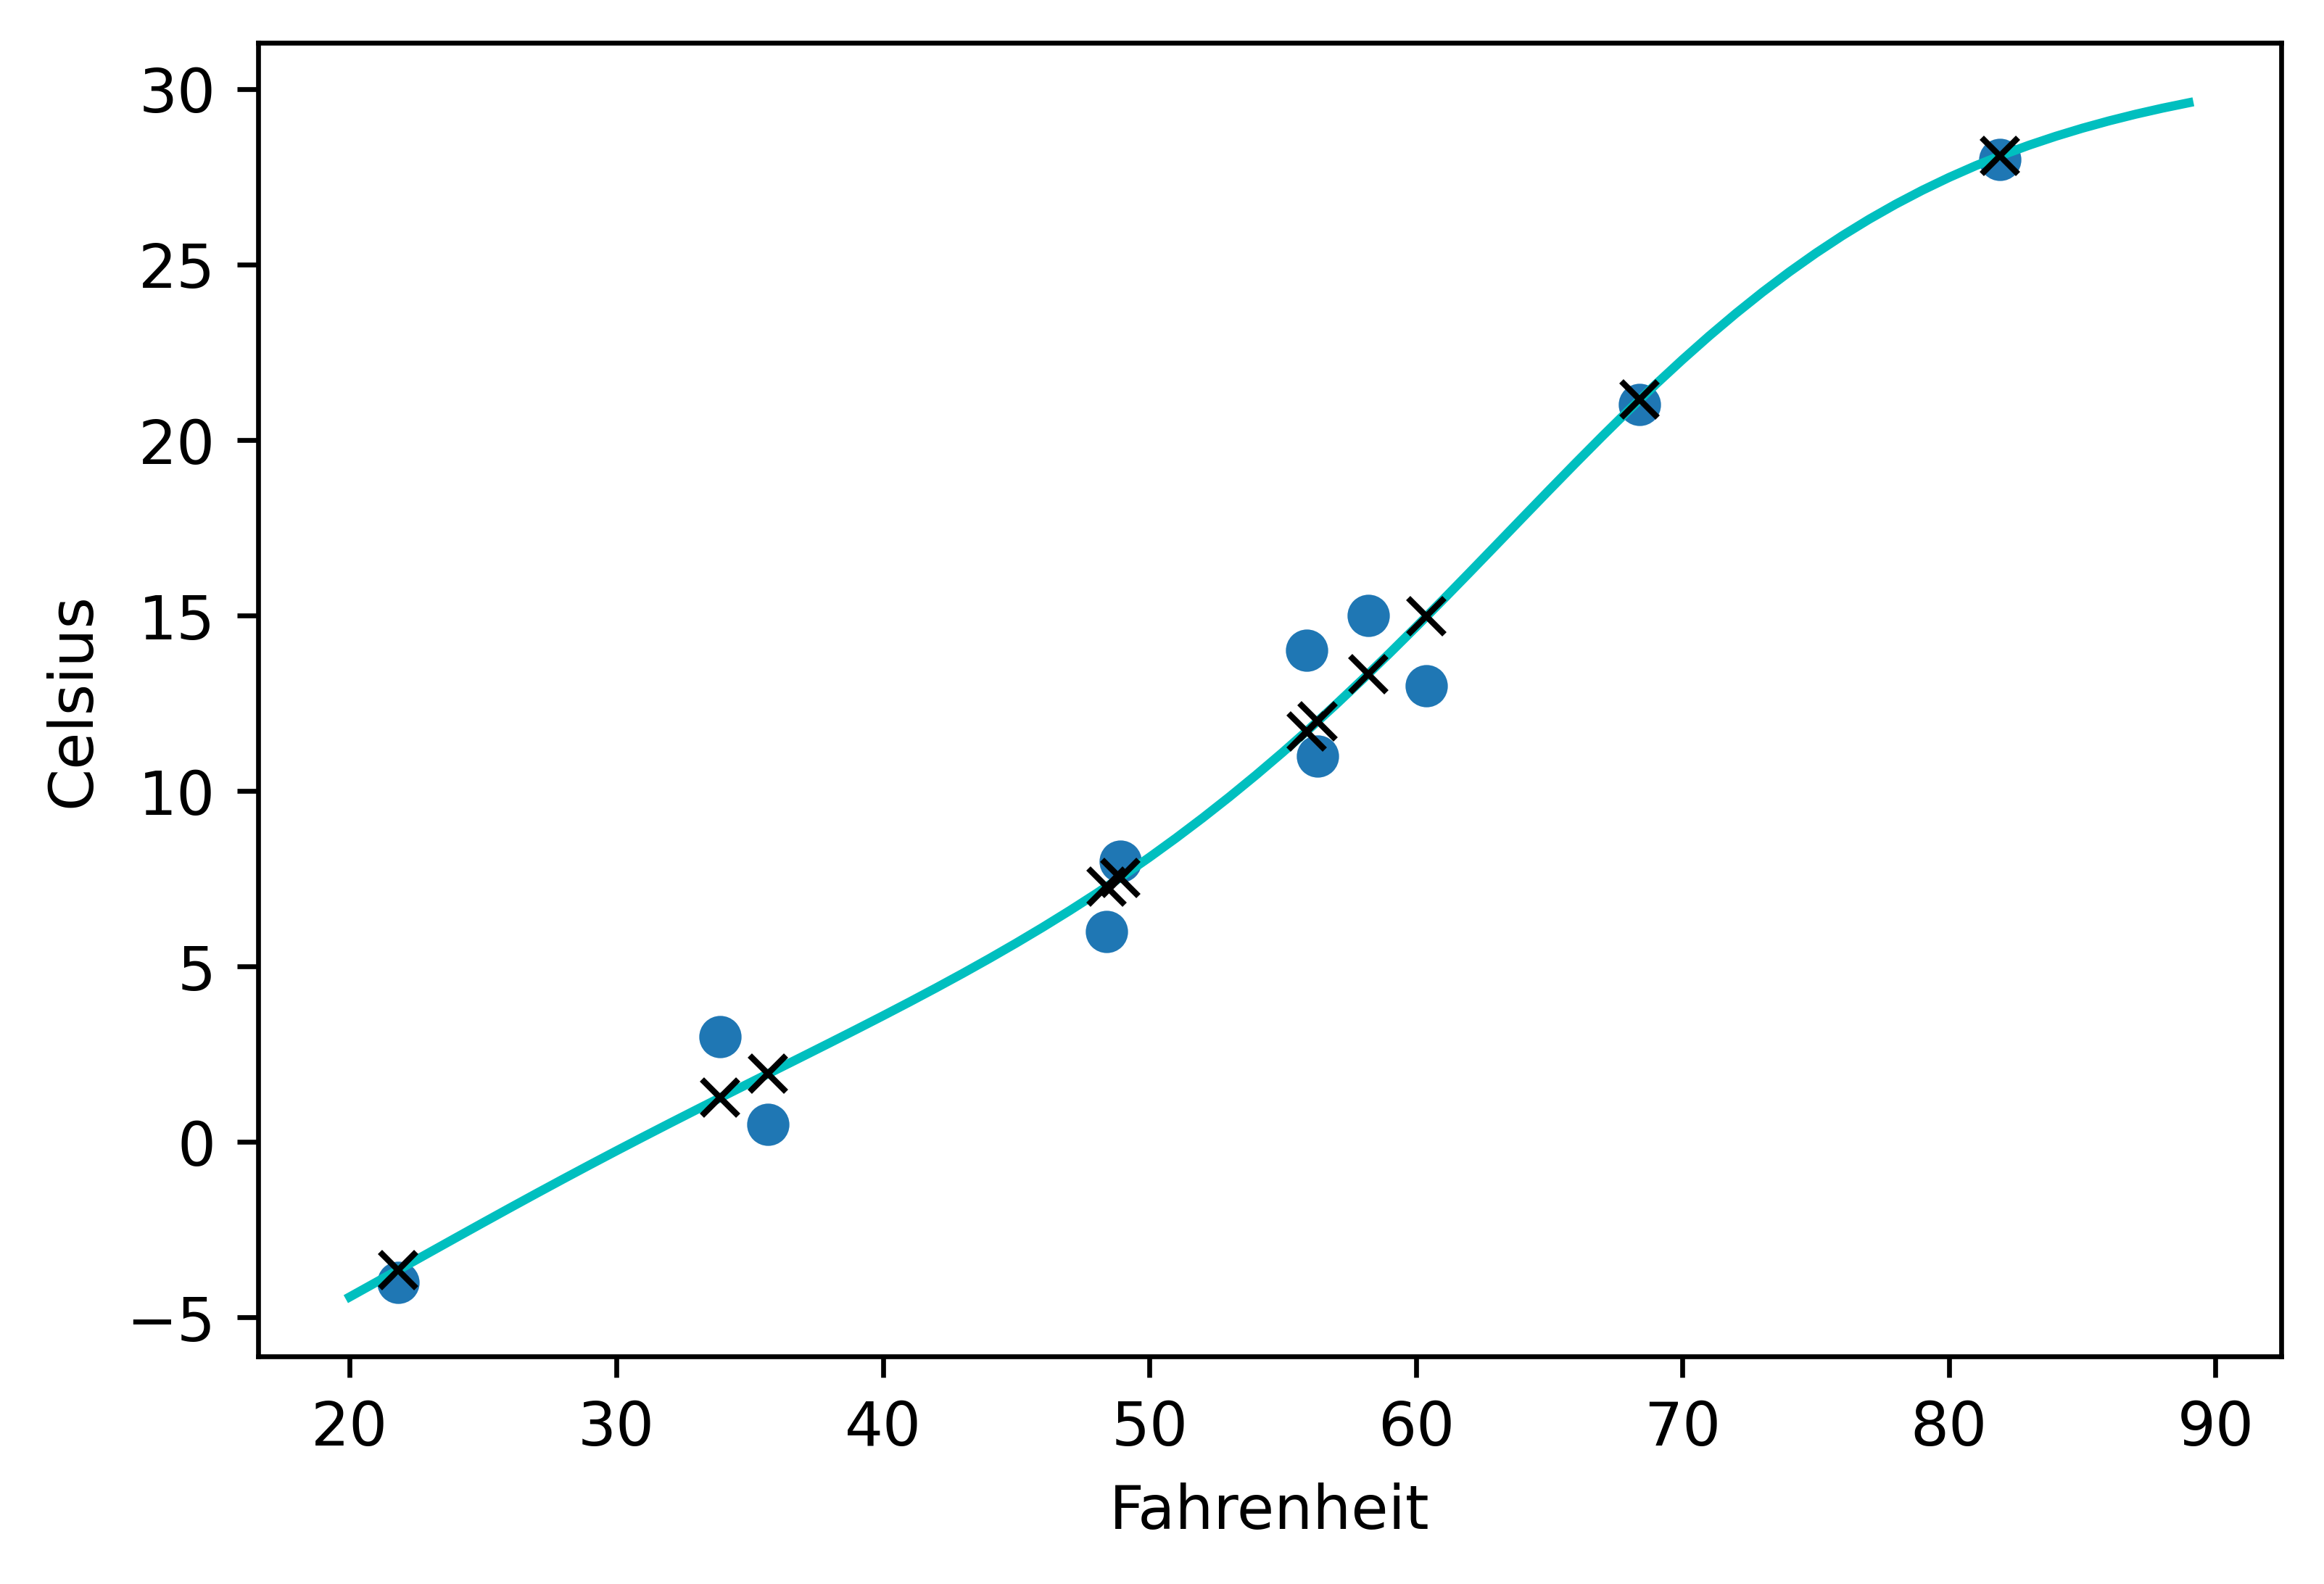

In [27]:
# Comparing to the linear model

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [ ]:
# The plot of our neural network model, with input data (circles) and
# model output (Xs). The continuous line shows behavior between samples